# Random Forest and GBDT Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>



The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
from bs4 import BeautifulSoup
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [04:24<00:00, 1378.18it/s]


In [11]:
#combining required columns
final['clean_text'] = preprocessed_reviews
final = final[['Time','clean_text','Score']]
#reseting index
final = final.reset_index(drop=True)

In [12]:
#sampling 100k points 
final_100k = final.sample(100000)
#sorting 100kpoints based on time
final_100k['Time'] = pd.to_datetime(final_100k['Time'],unit='s')
final_100k = final_100k.sort_values('Time')
#reseting index
final_100k = final_100k.reset_index(drop=True)

In [13]:
final_100k.head()

,Time,clean_text,Score
0,1999-10-08,witty little book makes son laugh loud recite ...,1
1,1999-10-25,remember seeing show aired television years ag...,1
2,2000-01-03,beetlejuice excellent funny movie keaton hilar...,1
3,2000-01-19,always enjoyed movie funny entertaining not he...,0
4,2000-01-24,bought apartment infested fruit flies hours tr...,1


In [14]:
final_100k['Score'].value_counts()

1    84563
0    15437
Name: Score, dtype: int64

observation: We have clearly an imbalenced dataset

In [15]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = final_100k['clean_text']
y = final_100k['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3)

# [4] Featurization


## [4.1] Bag of words

In [16]:
#applying bow on x_train and x_test
vectorizer = CountVectorizer()
vectorizer.fit(X_tr)
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_tr)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

In [18]:
print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_cv_bow is {}'.format(X_cv_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (49000, 42541)
shape of X_cv_bow is (21000, 42541)
shape of X_test_bow is (30000, 42541)


## Random Forest On BOW

Model with best parameters :
 {'max_depth': 15, 'n_estimators': 120}


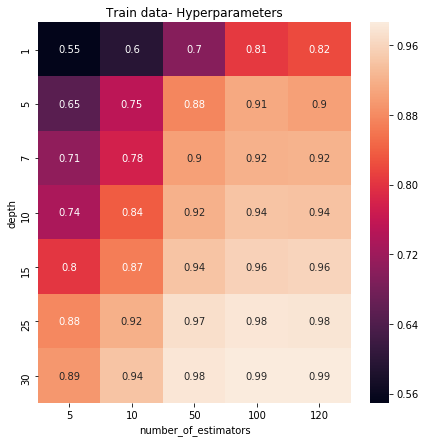

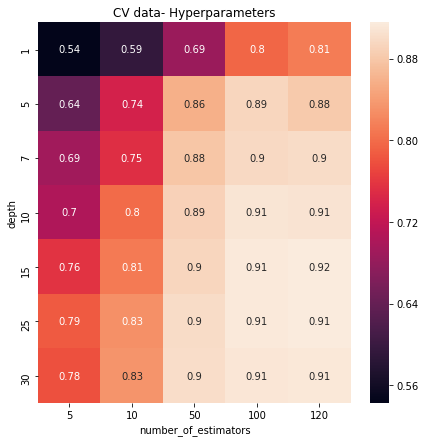

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
#no_of_estimators = [8, 16, 32, 64, 100, 200]
#maximumdepth = [ 2, 3, 5, 7, 9]
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc')
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)
###################################################################
fig = plt.figure(figsize=(7,7))
sns.heatmap(train_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(7,7))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.show()


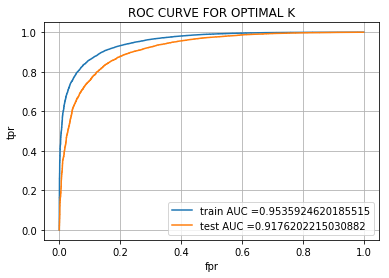

Area under train roc 0.9535924620185515
Area under test roc 0.9176202215030882


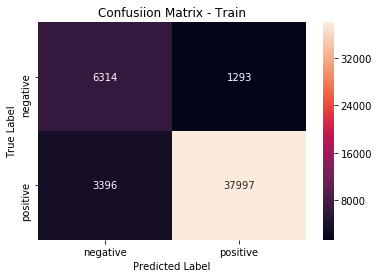

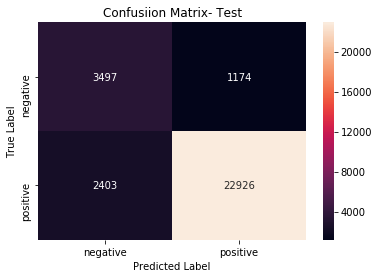

In [38]:
from sklearn.metrics import roc_curve, auc

optimal_depth = 15
optimal_estimators= 120
best_est = RandomForestClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators,class_weight='balanced')
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Top 20 features are: 
                   coef
great         0.031562
not           0.020988
waste         0.015291
delicious     0.014761
disappointed  0.014510
perfect       0.014153
thought       0.012045
love          0.011782
bad           0.010147
best          0.010112
wonderful     0.009809
good          0.009374
maybe         0.008574
highly        0.007957
favorite      0.007772
threw         0.007695
terrible      0.007420
worse         0.007208
snack         0.006935
product       0.006873


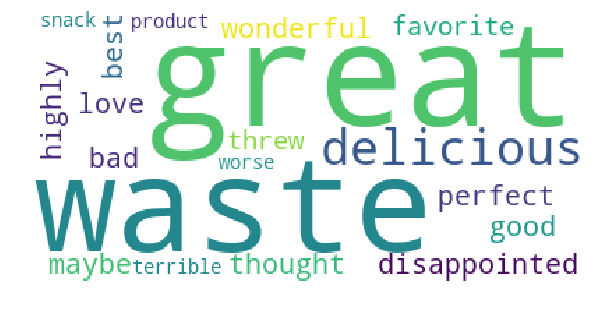

In [39]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = vectorizer.get_feature_names()
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## XGBOOST on BOW

Model with best parameters :
 {'max_depth': 25, 'n_estimators': 120}


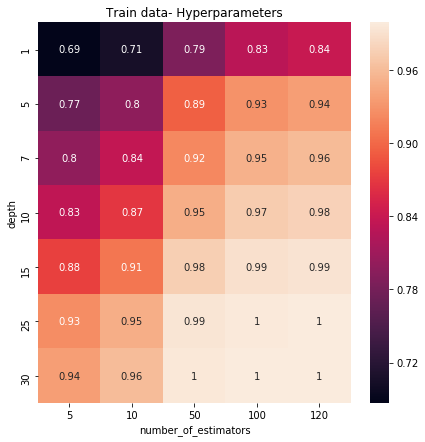

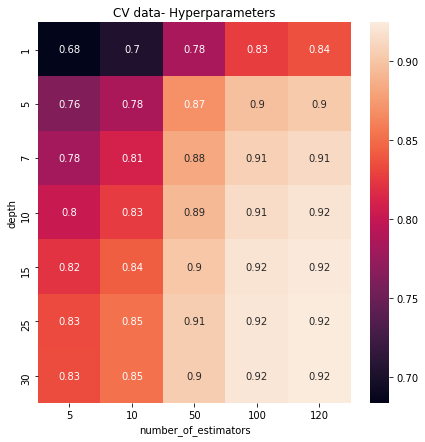

In [25]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc')
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)
###################################################################
fig = plt.figure(figsize=(7,7))
sns.heatmap(train_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(7,7))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.show()


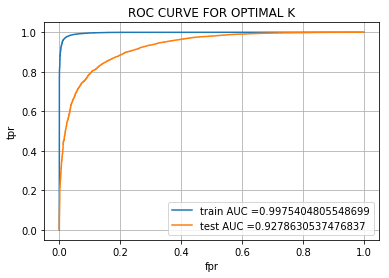

Area under train roc 0.9975404805548699
Area under test roc 0.9278630537476837


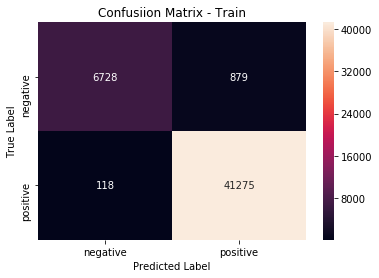

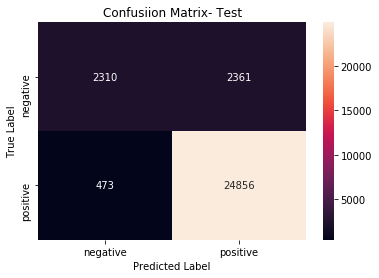

In [41]:
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

optimal_depth = 25
optimal_estimators= 120
best_est = XGBClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators,class_weight='balanced')
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Top 20 features are: 
                     coef
worst           0.005655
delicious       0.005057
perfect         0.004232
great           0.004057
best            0.003992
waste           0.003943
return          0.003911
highly          0.003616
easy            0.003611
excellent       0.003330
refund          0.003297
threw           0.003294
loves           0.003248
disappointment  0.003242
wonderful       0.003103
awful           0.002915
horrible        0.002848
front           0.002636
disappointing   0.002624
hooked          0.002598


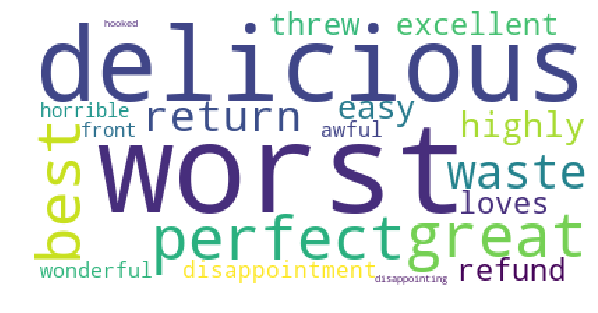

In [42]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = vectorizer.get_feature_names()
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# [4.2] TFIDF

In [44]:
#applying bow on x_train and x_test
vectorizer = TfidfVectorizer()
vectorizer.fit(X_tr)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_tr)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

## Random Forest on Tfidf

Model with best parameters :
 {'max_depth': 25, 'n_estimators': 120}


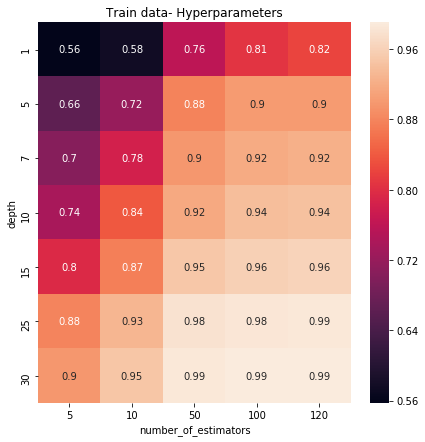

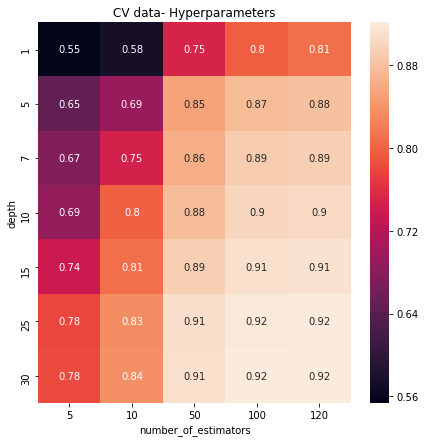

In [29]:

clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc')
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)
###################################################################
fig = plt.figure(figsize=(7,7))
sns.heatmap(train_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(7,7))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.show()


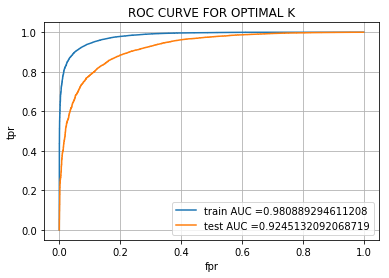

Area under train roc 0.980889294611208
Area under test roc 0.9245132092068719


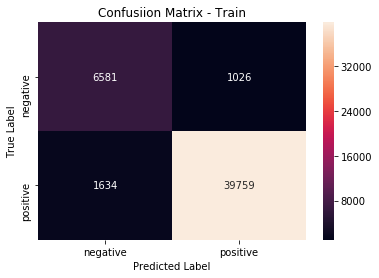

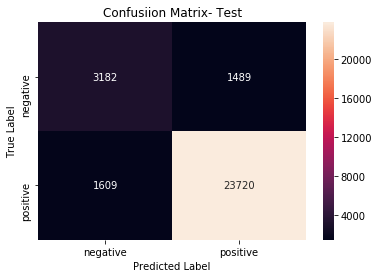

In [45]:
from sklearn.metrics import roc_curve, auc

optimal_depth = 25
optimal_estimators= 120
best_est = RandomForestClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators,class_weight='balanced')
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Top 20 features are: 
                   coef
great         0.031217
not           0.022400
disappointed  0.016476
perfect       0.013353
best          0.011791
bad           0.010452
delicious     0.010439
worst         0.009938
would         0.009900
good          0.008700
waste         0.007690
favorite      0.007331
money         0.007197
love          0.007043
thought       0.006738
terrible      0.006550
awful         0.006379
loves         0.006356
highly        0.006285
easy          0.006177


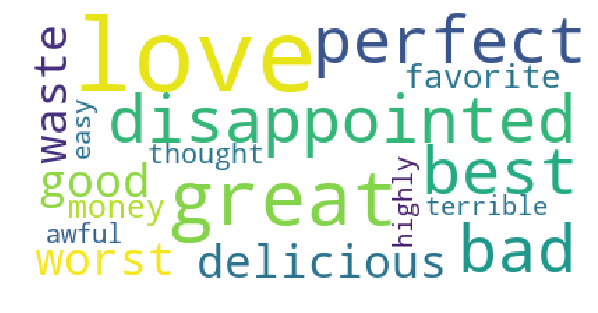

In [46]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = vectorizer.get_feature_names()
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## XGBOOST On Tfidf

Model with best parameters :
 {'max_depth': 25, 'n_estimators': 120}


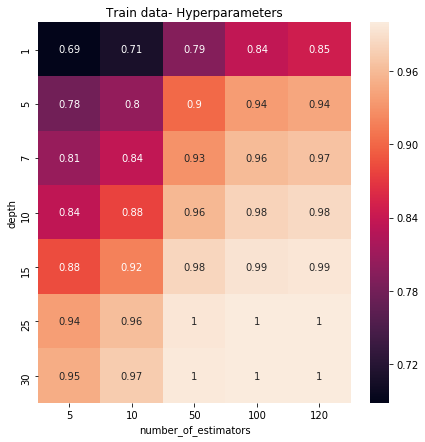

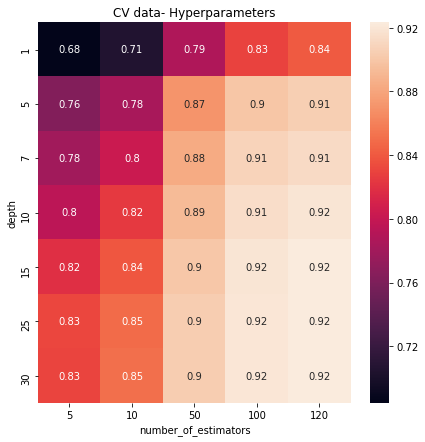

In [32]:

clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc')
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)
###################################################################
fig = plt.figure(figsize=(7,7))
sns.heatmap(train_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(7,7))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.show()


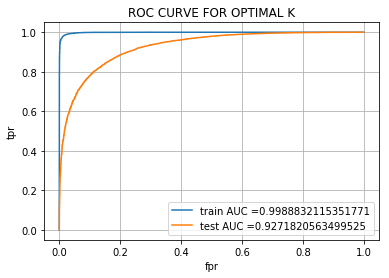

Area under train roc 0.9988832115351771
Area under test roc 0.9271820563499525


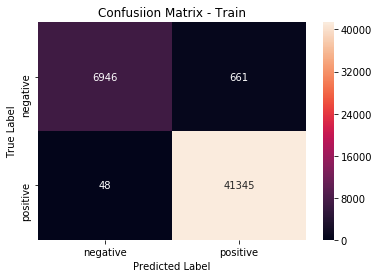

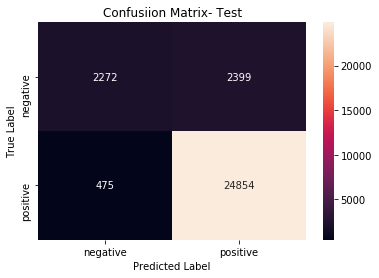

In [47]:
from sklearn.metrics import roc_curve, auc

optimal_depth = 25
optimal_estimators= 120
best_est = XGBClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators,class_weight = 'balanced')
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [4.3] AVG WORD2VEC

In [48]:
# Train your own Word2Vec model using your own text corpus
preprocessed_reviews = X_tr.values
train_sentance=[]
for sentance in preprocessed_reviews:
    train_sentance.append(sentance.split())

want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(train_sentance,min_count=5,size=50, workers=4)
w2v_words_train = list(w2v_model_train.wv.vocab)
#################################################################
# compute average word2vec for each review for train data.
preprocessed_reviews = X_tr.values
list_of_sentancetrain = []
for sentance in preprocessed_reviews:
    list_of_sentancetrain.append(sentance.split())


sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetrain): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

###########################################################
# compute average word2vec for each review for cv data.
preprocessed_reviews = X_cv.values
list_of_sentancecv = []
for sentance in preprocessed_reviews:
    list_of_sentancecv.append(sentance.split())

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancecv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

#################################################################

# compute average word2vec for each review for test data.
preprocessed_reviews = X_test.values
list_of_sentancetest = []
for sentance in preprocessed_reviews:
    list_of_sentancetest.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 49000/49000 [03:07<00:00, 261.14it/s]


49000
50


100%|██████████| 21000/21000 [01:22<00:00, 255.18it/s]


21000
50


100%|██████████| 30000/30000 [01:58<00:00, 253.84it/s]


30000
50


In [49]:
X_train_avgw2v = np.array(sent_vectors_train)
X_cv_avgw2v = np.array(sent_vectors_cv)
X_test_avgw2v = np.array(sent_vectors_test)

## Random Forest on AvgW2V

Model with best parameters :
 {'max_depth': 25, 'n_estimators': 120}


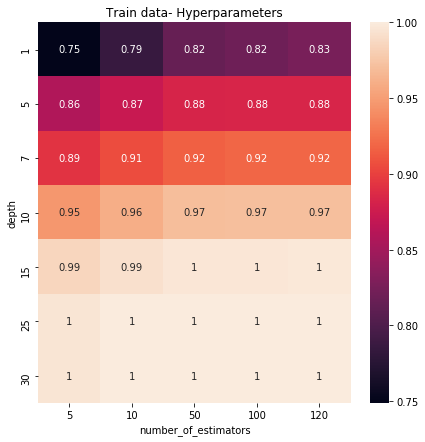

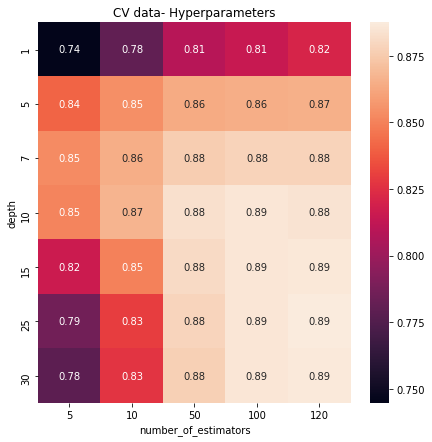

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc')
model.fit(X_train_avgw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)
###################################################################
fig = plt.figure(figsize=(7,7))
sns.heatmap(train_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(7,7))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.show()


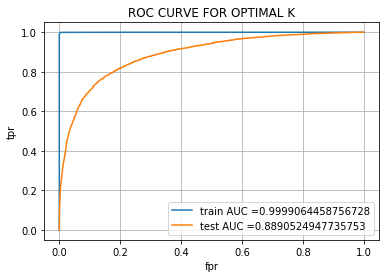

Area under train roc 0.9999064458756728
Area under test roc 0.8890524947735753


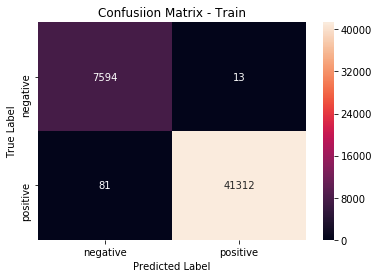

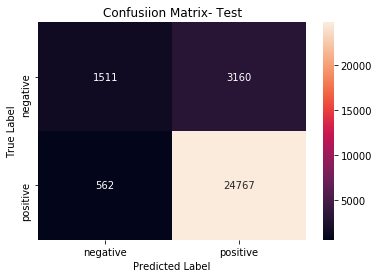

In [51]:
from sklearn.metrics import roc_curve, auc

optimal_depth = 25
optimal_estimators= 120
best_est = RandomForestClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators,class_weight='balanced')
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## XGBOOST On AvgW2V

Model with best parameters :
 {'max_depth': 25, 'n_estimators': 120}


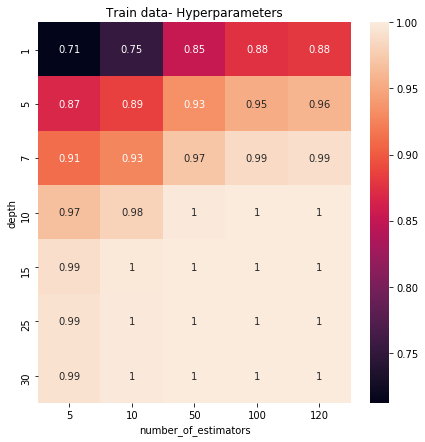

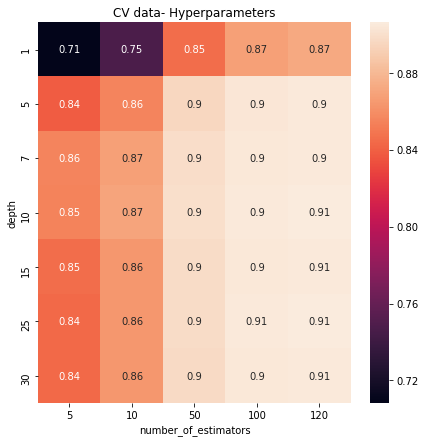

In [50]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc')
model.fit(X_train_avgw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)
###################################################################
fig = plt.figure(figsize=(7,7))
sns.heatmap(train_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(7,7))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.show()

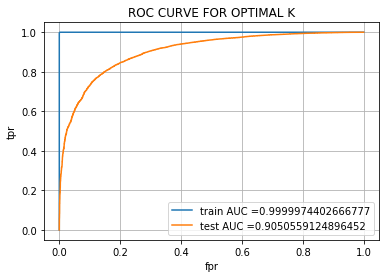

Area under train roc 0.9999974402666777
Area under test roc 0.9050559124896452


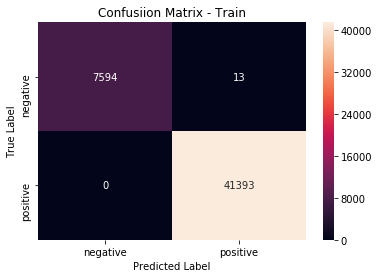

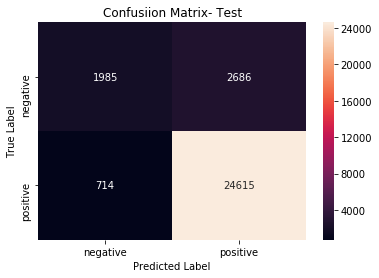

In [52]:
from sklearn.metrics import roc_curve, auc

optimal_depth = 25
optimal_estimators= 120
best_est = XGBClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators,class_weight = 'balanced')
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [4.4] TFIDF Word2Vec

In [53]:
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancetrain): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
#######################################################################################
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancecv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_vectors.append(sent_vec)
    row += 1
#####################################################################################################################
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancetest): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [20:24<00:00, 21.48it/s]


In [54]:
X_train_tfw2v = np.array(tfidf_train_vectors)
X_cv_tfw2v = np.array(tfidf_cv_vectors)
X_test_tfw2v = np.array(tfidf_test_vectors)

## Ransom Forest on Tfidf w2v

Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


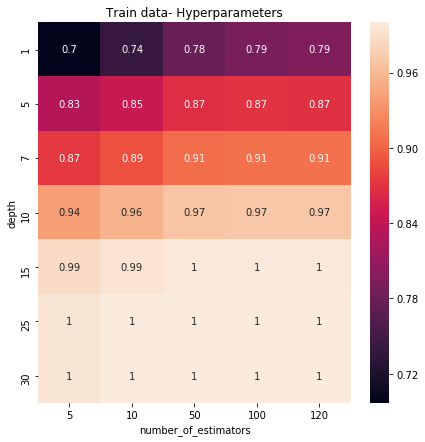

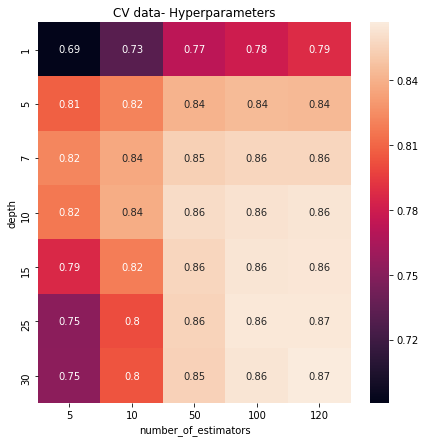

In [55]:


clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc')
model.fit(X_train_tfw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)
###################################################################
fig = plt.figure(figsize=(7,7))
sns.heatmap(train_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(7,7))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.show()


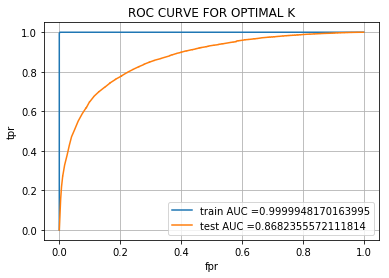

Area under train roc 0.9999948170163995
Area under test roc 0.8682355572111814


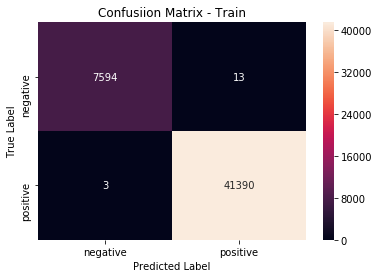

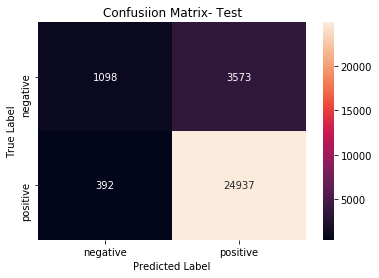

In [55]:

optimal_depth = 30
optimal_estimators= 120
best_est = RandomForestClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators,class_weight='balanced')
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_tfw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_tfw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## XGBOOST On TFIDF WORD2VEC

Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


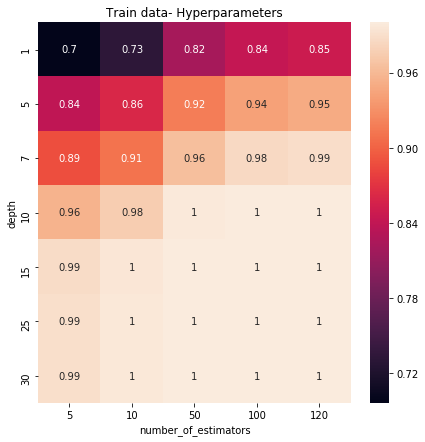

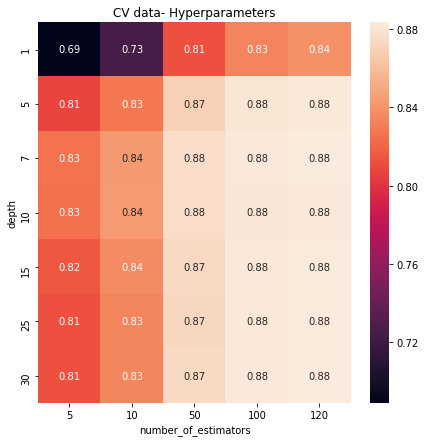

In [57]:

clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc')
model.fit(X_train_tfw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)
###################################################################
fig = plt.figure(figsize=(7,7))
sns.heatmap(train_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(7,7))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True)
plt.xlabel('number_of_estimators')
plt.ylabel('depth')
plt.show()

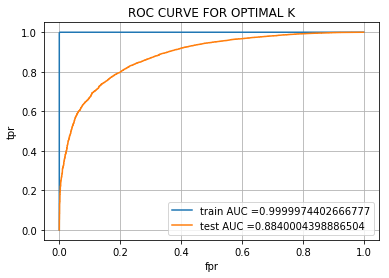

Area under train roc 0.9999974402666777
Area under test roc 0.8840004398886504


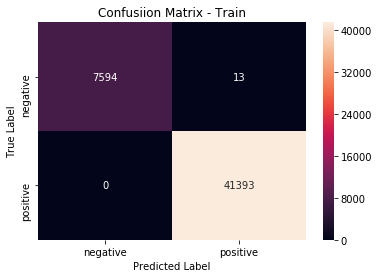

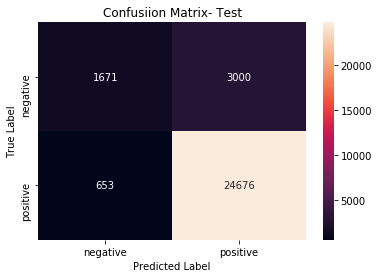

In [57]:
from sklearn.metrics import roc_curve, auc

optimal_depth = 30
optimal_estimators= 120
best_est = XGBClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators,class_weight='balanced')
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_tfw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_tfw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Conclusion

In [58]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","Hyperparam-no_of_estimators","Hyperparam-max_Depth","Train AUC", "Test AUC"]
z.add_row(["bow","random-forest",120,15,0.9535924620185515,0.9176202215030882])
z.add_row(["bow","xgboost",120,25,0.9975404805548699,0.9278630537476837])
z.add_row(["tfidf","random-forest",120,25,0.980889294611208,0.9245132092068719])
z.add_row(["tfidf","x-gboost",120,25,0.9988832115351771,0.9271820563499525])
z.add_row(["avgw2v","random-forest",120,25,0.9999064458756728,0.8890524947735753])
z.add_row(["avgw2v","x-gboost",120,25,0.9999974402666777,0.9050559124896452])
z.add_row(["tfidf-w2v","random-forest",120,30,0.9999948170163995,0.8682355572111814])
z.add_row(["tfidf-w2v","x-gboost",120,30,0.9999974402666777,0.8840004398886504])
print(z)

+-----------+---------------+-----------------------------+----------------------+--------------------+--------------------+
|   Vector  |   Algorithm   | Hyperparam-no_of_estimators | Hyperparam-max_Depth |     Train AUC      |      Test AUC      |
+-----------+---------------+-----------------------------+----------------------+--------------------+--------------------+
|    bow    | random-forest |             120             |          15          | 0.9535924620185515 | 0.9176202215030882 |
|    bow    |    xgboost    |             120             |          25          | 0.9975404805548699 | 0.9278630537476837 |
|   tfidf   | random-forest |             120             |          25          | 0.980889294611208  | 0.9245132092068719 |
|   tfidf   |    x-gboost   |             120             |          25          | 0.9988832115351771 | 0.9271820563499525 |
|   avgw2v  | random-forest |             120             |          25          | 0.9999064458756728 | 0.8890524947735753 |


*   We can see that bow and tfidf had better perfomance than avgw2v and tfidf w2v.
*   Also we can see xgboost algorithm performs slightly better thab random forest.
*   Overall we can say that algorithms performs good on this dataset.
